### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points. 

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either __pytorch__ or __tensorflow__ or any other framework (e.g. pure __keras__). Feel free to adapt the seminar code for your needs. For tensorflow version, consider `seminar_tf2.ipynb` as a starting point.


## Препроцессинг, честно взятый с семинара

In [1]:
# < A whole lot of your code > - models, charts, analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch

In [3]:
data = pd.read_csv("./Train_rev1.zip", compression='zip', index_col=None)
data.shape

(244768, 12)

In [4]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

In [5]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
203423,71911534,Principal Consultant Geologist England,We are currently working alongside an internat...,England,UK,full_time,permanent,Spencer Ogden,Engineering Jobs,75000,75000,strike-jobs.co.uk,11.225257
147932,70759188,Engineering Manager,Automotive Engineering Manager **** **** Com...,West Midlands,West Midlands,NaN,permanent,ATA Recruitment,Other/General Jobs,55000/annum,55000,cv-library.co.uk,10.915107
48195,68593238,Lead / Senior UX / UI Berkshire,This is a new and fantastic opportunity that w...,Reading,Reading,NaN,permanent,NonStop Recruitment Ltd,IT Jobs,45k - 60k pa + CAR,52500,jobsite.co.uk,10.868587


In [6]:
data[text_columns] = data[text_columns].fillna(method="ffill")

In [7]:
import nltk
#TODO YOUR CODE HERE

tokenizer = nltk.tokenize.WordPunctTokenizer()

data["FullDescription"] = data["FullDescription"].apply(lambda descrp: ' '.join(tokenizer.tokenize(descrp.lower())))
data["Title"] = data["Title"].apply(lambda title: ' '.join(tokenizer.tokenize(title.lower())))


In [8]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in both "Title" and "FullDescription" in total
for index, row in data.iterrows():
    token_counts.update(row['Title'].split())
    token_counts.update(row['FullDescription'].split())

In [9]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)#TODO<YOUR CODE HERE>

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [10]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

Тут добавил параметр минимальной длины (показалось что удобно это сделать на месте)

In [11]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None, min_len=10):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    max_len = max(max_len, min_len)
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [12]:
len(token_to_id)

34158

In [16]:
import gensim.downloader 
# embeddings = gensim.downloader.load("fasttext-wiki-news-subwords-300")

[==================================================] 100.0% 958.5/958.4MB downloaded


In [19]:
counter = 0
for token in tokens:
    if token not in embeddings:
        counter += 1
        
print(counter)

9945


## Эмбеддинги

Решил не рисковать и взять средний размер - выбор пал на GloVe6B-100. Токены для которых не нашлось вектора заполнял случайно стандартно нормально

In [13]:
from gensim.models import KeyedVectors
glove_embs = KeyedVectors.load_word2vec_format('glove.6B.100d.txt', binary=False, no_header=True)

In [14]:
counter = 0
for token in tokens:
    if token not in glove_embs:
        counter += 1
        
print(counter)

7935


In [15]:
emb_util_lambda = lambda idx: glove_embs[tokens[idx]] if tokens[idx] in glove_embs else list(np.random.normal(size=100))

In [16]:
embeddings_tensor_glove = torch.FloatTensor([emb_util_lambda(idx) for idx in range(len(tokens))])

/tmp/ipykernel_3373/1962516131.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  embeddings_tensor_glove = torch.FloatTensor([emb_util_lambda(idx) for idx in range(len(tokens))])


In [17]:
embeddings_tensor_glove.shape

torch.Size([34158, 100])

## Еще немного препроцессинга 

In [18]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [19]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F


device = 'cuda' if torch.cuda.is_available() else 'cpu'


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0.1, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [21]:
make_batch(data_train[:3], max_len=10)

{'Title': tensor([[27645, 29893, 33674,     1,     1,     1,     1,     1,     1,     1],
         [29239,   197, 19175, 20042, 15554, 23162,  4051,     1,     1,     1],
         [10609, 30412, 17746,    33,  8705, 29157,    65,     1,     1,     1]],
        device='cuda:0'),
 'FullDescription': tensor([[27645, 29893, 33674, 32939,   982,     0,     0, 33674, 16451, 32939],
         [29239,   197, 19175,     0, 15554, 23162,     0, 25511,   907,    82],
         [30746, 21956, 20601,  6409,     0,  8165, 27493,   982,     0, 17746]],
        device='cuda:0'),
 'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),
 'Log1pSalary': tensor([ 9.7115, 10.4631, 10.7144], device='cuda:0')}

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## Блоки и пулинги

Реализовано из ~~говна и палок~~ экоматериалов, приличная доля позаимствована из дз по глубинному зрению и затем заботливо адаптирована под 1d формат. Конфиги указанные в параметрах по умолчанию использовались для обучения

In [55]:
def create_stem(out_channels, in_channels=100):
    return nn.Sequential(
        nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2, padding=0), # YOUR CODE; conv 2x2, stride 2, padding 0
        nn.BatchNorm1d(out_channels)
    )

def create_downscale_block(in_channels, out_channels):
    return nn.Sequential(
        nn.BatchNorm1d(in_channels),
        nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2, padding=0)  # YOUR CODE: conv 2x2, stride 2, padding 0
    )


class ConvNextLikeBlock(nn.Module):
    def __init__(self, dim, drop_rate=0.1):
        super().__init__()
        
        self.depthwise_conv = nn.Conv1d(in_channels=dim, out_channels=dim, kernel_size=5, padding=2, groups=dim)  # depthwise conv 5x5, padding 2, dim->dim
        
        self.norm = nn.BatchNorm1d(dim)
        
        self.pointwise_conv1 = nn.Conv1d(in_channels=dim, out_channels=dim*4, kernel_size=1)  # 1x1 conv, dim -> dim*4  YOUR CODE

        self.activation = nn.GELU()
        
        self.pointwise_conv2 = nn.Conv1d(in_channels=dim*4, out_channels=dim, kernel_size=1)  # 1x1 conv, 4*dim -> dim YOUR CODE

        self.dropout = nn.Dropout(drop_rate)

    def forward(self, x):
        input = x
        x = self.depthwise_conv(x)
        x = self.norm(x)
        x = self.pointwise_conv1(x)
        x = self.activation(x)
        x = self.pointwise_conv2(x)

        x = input + self.dropout(x)
        return x
    
    
def create_convnext_like_network(config=[[256] * 2, [512] * 2], use_bn=True, drop_rate=0.1):
    """
    Creates ConvNeXt like network according to config
    """
    model = nn.Sequential()

    default_config = [[64] * 2, [128] * 2, [256] * 2, [1024] * 2]

    config = config or default_config

    stem_out_channels = config[0][0]
    model.add_module('stem', create_stem(stem_out_channels))

    layer_index = 0
    for block_index in range(len(config)):
        for layer_index_in_block in range(len(config[block_index])):
            out_channels = config[block_index][layer_index_in_block]

            model.add_module(f"{block_index}_{layer_index_in_block}", ConvNextLikeBlock(dim=out_channels, drop_rate=drop_rate))
            layer_index += 1
            
        if block_index != len(config) - 1:
            downscale_in_channels = out_channels
            downscale_out_channels = config[block_index+1][0]
            model.add_module(f'downscale_{block_index}', create_downscale_block(downscale_in_channels, downscale_out_channels))
            
    return model

In [43]:
class ResNetLikeBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding='same'):
        super().__init__()
        # YOUR CODE: define conv1, bn1, relu1, conv2, bn2 for residual branch computation 
        self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        self.relu2 = nn.ReLU()
        
        self.conv3 = None  # conv for main branch adopatation
        if in_channels != out_channels or stride != 1:
            self.conv3 = nn.Conv1d(in_channels, out_channels, 1, stride, padding=0)
        
    def forward(self, x):

        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.relu1(residual)
        
        residual = self.conv2(residual)
        residual = self.bn2(residual)     
        
        if self.conv3 is not None:
            x = self.conv3(x)
            
        result = self.relu2(residual + x)
        return result

def create_resnet_like_network(blocks_config=[[128] * 2, [1024] * 2]):
    model = nn.Sequential()
    
    config = [[128] * 3, [256] * 3, [512] * 3, [1024] * 3] if blocks_config is None else blocks_config
    
    model.add_module('init_conv', nn.Conv1d(100, 128, kernel_size=7, stride=2, padding=3))
    model.add_module('init_bn', nn.BatchNorm1d(128))

    in_channels = 128
    for i in range(len(config)):
        for j in range(len(config[i])):
            out_channels = config[i][j]
            stride = 2 if i != 0 and j == 0 else 1
            # YOUR CODE: add ResNetBlock2 module to model
            model.add_module(f'resblock_{in_channels}_{out_channels}', ResNetLikeBlock(in_channels, out_channels)) 
            in_channels = out_channels

    return model

Этот блок не успел поюзать

In [24]:
class ResNeXtLikeBlock(nn.Module):
    def __init__(self, dim, drop_rate=0.1):
        super().__init__()
        
        self.inp_conv = nn.Conv1d(in_channels=dim, out_channels=dim, kernel_size=1)
        self.inp_bn = nn.BatchNorm1d(dim)
        
        # Define the first convolution layer
        self.conv1 = nn.Conv1d(in_channels=dim, out_channels=dim*4, kernel_size=1, groups=dim / 4)
        self.bn1 = nn.BatchNorm1d(dim*4)
        
        self.act1 = nn.GELU()
        
        # Define the second convolution layer
        self.conv2 = nn.Conv1d(in_channels=dim*4, out_channels=dim*4, kernel_size=5, padding='same')
        self.bn2 = nn.BatchNorm1d(dim*4)

        self.act2 = nn.GELU()

        # Define the shortcut connection
        self.conv3 = nn.Conv1d(in_channels=dim*4, out_channels=dim, kernel_size=1)
        self.bn3 = nn.BatchNorm1d(dim)
        
        self.dropout = nn.Dropout(drop_rate)
        
        self.act_fin = nn.GELU()

    def forward(self, x):
        inp = x
        
        x = self.act1(self.bn1(self.conv1(x)))
        x = self.act2(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))

        return self.act_fin(self.inp_bn(self.inp_conv(inp)) + self.dropout(x))


In [25]:
class GlobalAveragePool(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return torch.mean(x, dim=-1)

class GlobalMaxPool(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x.max(dim=-1).values
    
class GlobalSoftmaxPool(nn.Module):
    def __init__(self):
        super().__init__()
        self.sm = nn.Softmax(dim=-1)

    def forward(self, x):
        return torch.mean(x * self.sm(x), dim=-1)

In [26]:
class TextEncoder(nn.Module):
    def __init__(self, block_type='resnet', pooling_type='average', initial_embedding_weights=embeddings_tensor_glove, hid_size=100):
        super().__init__()
        hid_size = initial_embedding_weights.shape[1]

        self.emb = nn.Embedding.from_pretrained(initial_embedding_weights)

        self.main_part = None
        if block_type == 'resnet':
            self.main_part = create_resnet_like_network()
        elif block_type == 'convnext':
            self.main_part = create_convnext_like_network()
        else:
            raise ValueError
            
                
        self.pool = None
        
        if pooling_type == 'average':
            self.pool = GlobalAveragePool()
        elif pooling_type == 'softmax':
            self.pool = GlobalSoftmaxPool()
        elif pooling_type == 'max':
            self.pool = GlobalMaxPool()
        else:
            raise ValueError
            
        
    def forward(self, x):
        x = self.emb(x)
        x.swapaxes_(1, 2)
        x = self.main_part(x)
        x = self.pool(x)
        return x

    
    

In [27]:
class CategoricalEncoder(nn.Module):
    def __init__(self, features_num, last_size=256):
        super().__init__()
        self.mlp_block = nn.Sequential()
        self.mlp_block.add_module('linear_1', nn.Linear(features_num, 1024))
        self.mlp_block.add_module('relu_1', nn.ReLU())
        self.mlp_block.add_module('linear_2', nn.Linear(1024, 512))
        self.mlp_block.add_module('relu_2', nn.ReLU())
        self.mlp_block.add_module('linear_3', nn.Linear(512, last_size))
        self.mlp_block.add_module('relu_3', nn.ReLU())
        
    def forward(self, x):
        return self.mlp_block(x)

In [61]:
class SalaryPredictor(nn.Module):
    def __init__(self, block_type='resnet', pooling_type='average', n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64, last_size_cat=256):
        super().__init__()
        #  YOUR CODE HERE
        self.title_enc = TextEncoder(block_type, pooling_type)
        self.full_desc_enc = TextEncoder(block_type, pooling_type)
        self.cat_enc = CategoricalEncoder(n_cat_features)
        self.mlp_block = nn.Sequential(
            nn.Linear(1024 * 2 + 256, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 1),
        )

        
    def forward(self, batch):
        # YOUR CODE HERE
        title_processed = self.title_enc(batch['Title'])
        full_desc_processed = self.full_desc_enc(batch['FullDescription'])
        cat_features_processed = self.cat_enc(batch['Categorical'])
        concated = torch.cat((title_processed, full_desc_processed, cat_features_processed), 1)
        return self.mlp_block(concated)

        
        

## Утилиты для обучения

In [29]:
model = SalaryPredictor()

In [30]:
model = SalaryPredictor().to(device)
batch = make_batch(data_train[:100], device=device)
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred.squeeze_(1), batch[TARGET_COLUMN])
print(dummy_pred.shape)
assert dummy_pred.shape == torch.Size([100])
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

torch.Size([100])


In [31]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch
        
        if not cycle: break

In [32]:
from tqdm.auto import tqdm

BATCH_SIZE = 32
EPOCHS = 20

In [33]:
def print_metrics(model, val_metrics, data, batch_size=BATCH_SIZE, name="", device=torch.device('cpu'), **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            batch_pred = model(batch)
            batch_pred.squeeze_(1)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    val_metrics['mse_loss'].append(mse)
    val_metrics['mae_loss'].append(mae)
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae


In [57]:
from collections import defaultdict

def model_train(model):
    criterion = nn.MSELoss(reduction='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0, last_epoch=-1, verbose=False)
    val_metrics = defaultdict(list)
    for epoch in range(EPOCHS):
        print(f"epoch: {epoch}")
        model.train()
        for i, batch in tqdm(enumerate(
                iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
                total=len(data_train) // BATCH_SIZE
            ):
            pred = model(batch)
            pred.squeeze_(1)

            loss = criterion(pred, batch[TARGET_COLUMN])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        sched.step()

        print_metrics(model, val_metrics, data_val, device=device)
    return val_metrics

## Непосредственно, обучение

In [47]:
validation_scores = {}

In [48]:
# config: [[128] * 2, [1024] * 2]


model = SalaryPredictor('resnet', 'average').to(device)
val_score = model_train(model)
validation_scores['resnet_average'] = val_score

epoch: 0


6120it [01:27, 69.66it/s]                          


 results:
Mean square error: 0.09878
Mean absolute error: 0.23742
epoch: 1


6120it [01:27, 69.80it/s]                          


 results:
Mean square error: 0.09146
Mean absolute error: 0.22531
epoch: 2


6120it [01:28, 69.30it/s]                          


 results:
Mean square error: 0.09020
Mean absolute error: 0.22640
epoch: 3


6120it [01:28, 69.47it/s]                          


 results:
Mean square error: 0.08009
Mean absolute error: 0.21205
epoch: 4


6120it [01:28, 69.53it/s]                          


 results:
Mean square error: 0.07317
Mean absolute error: 0.20143
epoch: 5


6120it [01:30, 67.53it/s]                          


 results:
Mean square error: 0.07529
Mean absolute error: 0.20530
epoch: 6


6120it [01:27, 70.02it/s]                          


 results:
Mean square error: 0.08731
Mean absolute error: 0.22562
epoch: 7


6120it [01:27, 69.63it/s]                          


 results:
Mean square error: 0.07176
Mean absolute error: 0.19835
epoch: 8


6120it [01:27, 70.09it/s]                          


 results:
Mean square error: 0.07596
Mean absolute error: 0.20641
epoch: 9


6120it [01:27, 69.76it/s]                          


 results:
Mean square error: 0.06893
Mean absolute error: 0.19348
epoch: 10


6120it [01:28, 69.36it/s]                          


 results:
Mean square error: 0.06711
Mean absolute error: 0.19097
epoch: 11


6120it [01:27, 69.97it/s]                          


 results:
Mean square error: 0.06789
Mean absolute error: 0.19348
epoch: 12


6120it [01:27, 69.61it/s]                          


 results:
Mean square error: 0.06878
Mean absolute error: 0.19498
epoch: 13


6120it [01:27, 70.10it/s]                          


 results:
Mean square error: 0.06648
Mean absolute error: 0.18919
epoch: 14


6120it [01:27, 70.16it/s]                          


 results:
Mean square error: 0.06581
Mean absolute error: 0.18791
epoch: 15


6120it [01:27, 69.84it/s]                          


 results:
Mean square error: 0.06594
Mean absolute error: 0.18785
epoch: 16


6120it [01:28, 69.42it/s]                          


 results:
Mean square error: 0.06637
Mean absolute error: 0.18831
epoch: 17


6120it [01:28, 69.35it/s]                          


 results:
Mean square error: 0.06602
Mean absolute error: 0.18856
epoch: 18


6120it [01:28, 68.79it/s]                          


 results:
Mean square error: 0.06560
Mean absolute error: 0.18710
epoch: 19


6120it [01:31, 66.93it/s]                          


 results:
Mean square error: 0.06574
Mean absolute error: 0.18745


In [58]:
#config=[[256] * 2, [512] * 2]
model = SalaryPredictor('convnext', 'average').to(device)
val_score = model_train(model)
validation_scores['convnext_average'] = val_score

epoch: 0


6120it [01:44, 58.74it/s]                          


 results:
Mean square error: 0.21671
Mean absolute error: 0.33957
epoch: 1


6120it [01:34, 64.83it/s]                          


 results:
Mean square error: 0.19183
Mean absolute error: 0.32388
epoch: 2


6120it [01:33, 65.13it/s]                          


 results:
Mean square error: 0.09515
Mean absolute error: 0.23101
epoch: 3


6120it [01:34, 65.08it/s]                          


 results:
Mean square error: 0.12820
Mean absolute error: 0.25297
epoch: 4


6120it [01:34, 64.90it/s]                          


 results:
Mean square error: 0.08598
Mean absolute error: 0.22186
epoch: 5


6120it [01:34, 64.72it/s]                          


 results:
Mean square error: 0.07795
Mean absolute error: 0.20961
epoch: 6


6120it [01:34, 64.65it/s]                          


 results:
Mean square error: 0.07595
Mean absolute error: 0.20554
epoch: 7


6120it [01:34, 64.53it/s]                          


 results:
Mean square error: 0.07812
Mean absolute error: 0.20628
epoch: 8


6120it [01:42, 59.59it/s]                          


 results:
Mean square error: 0.07899
Mean absolute error: 0.20689
epoch: 9


6120it [01:42, 59.98it/s]                          


 results:
Mean square error: 0.06956
Mean absolute error: 0.19551
epoch: 10


6120it [01:34, 64.84it/s]                          


 results:
Mean square error: 0.06788
Mean absolute error: 0.19342
epoch: 11


6120it [01:36, 63.70it/s]                          


 results:
Mean square error: 0.06622
Mean absolute error: 0.19116
epoch: 12


6120it [01:43, 59.27it/s]                          


 results:
Mean square error: 0.09174
Mean absolute error: 0.21808
epoch: 13


6120it [01:34, 64.78it/s]                          


 results:
Mean square error: 0.06884
Mean absolute error: 0.19345
epoch: 14


6120it [01:34, 64.99it/s]                          


 results:
Mean square error: 0.07504
Mean absolute error: 0.19253
epoch: 15


6120it [01:34, 64.97it/s]                          


 results:
Mean square error: 0.06781
Mean absolute error: 0.19075
epoch: 16


6120it [01:33, 65.38it/s]                          


 results:
Mean square error: 0.06635
Mean absolute error: 0.18964
epoch: 17


6120it [01:33, 65.38it/s]                          


 results:
Mean square error: 0.06440
Mean absolute error: 0.18611
epoch: 18


6120it [01:34, 65.00it/s]                          


 results:
Mean square error: 0.07243
Mean absolute error: 0.19344
epoch: 19


6120it [01:38, 61.92it/s]                          


 results:
Mean square error: 0.06761
Mean absolute error: 0.18895


In [59]:
model = SalaryPredictor('convnext', 'softmax').to(device)
val_score = model_train(model)
validation_scores['convnext_softmax'] = val_score

epoch: 0


6120it [01:43, 59.05it/s]                          


 results:
Mean square error: 22.90501
Mean absolute error: 2.25808
epoch: 1


6120it [01:40, 60.85it/s]                          


 results:
Mean square error: 0.10121
Mean absolute error: 0.23852
epoch: 2


6120it [01:41, 60.13it/s]                          


 results:
Mean square error: 0.09011
Mean absolute error: 0.22050
epoch: 3


6120it [01:35, 63.76it/s]                          


 results:
Mean square error: 0.07442
Mean absolute error: 0.20246
epoch: 4


6120it [01:35, 63.95it/s]                          


 results:
Mean square error: 0.06979
Mean absolute error: 0.19706
epoch: 5


6120it [01:35, 63.99it/s]                          


 results:
Mean square error: 0.06969
Mean absolute error: 0.19748
epoch: 6


6120it [01:35, 63.96it/s]                          


 results:
Mean square error: 0.07060
Mean absolute error: 0.19790
epoch: 7


6120it [01:35, 63.92it/s]                          


 results:
Mean square error: 0.06555
Mean absolute error: 0.18933
epoch: 8


6120it [01:34, 64.51it/s]                          


 results:
Mean square error: 0.06375
Mean absolute error: 0.18566
epoch: 9


6120it [01:35, 64.15it/s]                          


 results:
Mean square error: 0.07456
Mean absolute error: 0.20542
epoch: 10


6120it [01:35, 64.23it/s]                          


 results:
Mean square error: 0.07184
Mean absolute error: 0.19828
epoch: 11


6120it [01:35, 64.09it/s]                          


 results:
Mean square error: 0.06732
Mean absolute error: 0.19163
epoch: 12


6120it [01:35, 63.88it/s]                          


 results:
Mean square error: 0.06236
Mean absolute error: 0.18344
epoch: 13


6120it [01:35, 63.77it/s]                          


 results:
Mean square error: 0.06388
Mean absolute error: 0.18562
epoch: 14


6120it [01:36, 63.67it/s]                          


 results:
Mean square error: 0.06149
Mean absolute error: 0.18127
epoch: 15


6120it [01:35, 63.86it/s]                          


 results:
Mean square error: 0.06136
Mean absolute error: 0.18083
epoch: 16


6120it [01:36, 63.72it/s]                          


 results:
Mean square error: 0.06196
Mean absolute error: 0.18173
epoch: 17


6120it [01:36, 63.64it/s]                          


 results:
Mean square error: 0.06256
Mean absolute error: 0.18285
epoch: 18


6120it [01:35, 63.84it/s]                          


 results:
Mean square error: 0.06154
Mean absolute error: 0.18092
epoch: 19


6120it [01:35, 64.15it/s]                          


 results:
Mean square error: 0.06233
Mean absolute error: 0.18194


In [62]:
model = SalaryPredictor('resnet', 'softmax').to(device)
val_score = model_train(model)
validation_scores['resnet_softmax'] = val_score

epoch: 0


6120it [01:31, 66.95it/s]                          


 results:
Mean square error: 0.11297
Mean absolute error: 0.26313
epoch: 1


6120it [01:31, 66.93it/s]                          


 results:
Mean square error: 0.09784
Mean absolute error: 0.24001
epoch: 2


6120it [01:31, 66.95it/s]                          


 results:
Mean square error: 0.07947
Mean absolute error: 0.20984
epoch: 3


6120it [01:31, 67.22it/s]                          


 results:
Mean square error: 0.08376
Mean absolute error: 0.21981
epoch: 4


6120it [01:31, 67.17it/s]                          


 results:
Mean square error: 0.07419
Mean absolute error: 0.20244
epoch: 5


6120it [01:30, 67.28it/s]                          


 results:
Mean square error: 0.07337
Mean absolute error: 0.20136
epoch: 6


6120it [01:31, 66.81it/s]                          


 results:
Mean square error: 0.07879
Mean absolute error: 0.21026
epoch: 7


6120it [01:32, 66.45it/s]                          


 results:
Mean square error: 0.07263
Mean absolute error: 0.20012
epoch: 8


6120it [01:32, 66.26it/s]                          


 results:
Mean square error: 0.06787
Mean absolute error: 0.19261
epoch: 9


6120it [01:31, 66.64it/s]                          


 results:
Mean square error: 0.06708
Mean absolute error: 0.19107
epoch: 10


6120it [01:32, 66.15it/s]                          


 results:
Mean square error: 0.06691
Mean absolute error: 0.19074
epoch: 11


6120it [01:31, 66.57it/s]                          


 results:
Mean square error: 0.06827
Mean absolute error: 0.19112
epoch: 12


6120it [01:31, 66.98it/s]                          


 results:
Mean square error: 0.08076
Mean absolute error: 0.20170
epoch: 13


6120it [01:31, 67.06it/s]                          


 results:
Mean square error: 0.06433
Mean absolute error: 0.18629
epoch: 14


6120it [01:31, 67.01it/s]                          


 results:
Mean square error: 0.07214
Mean absolute error: 0.19635
epoch: 15


6120it [01:31, 66.98it/s]                          


 results:
Mean square error: 0.06482
Mean absolute error: 0.18619
epoch: 16


6120it [01:31, 66.97it/s]                          


 results:
Mean square error: 0.06385
Mean absolute error: 0.18471
epoch: 17


6120it [01:31, 67.06it/s]                          


 results:
Mean square error: 0.06447
Mean absolute error: 0.18514
epoch: 18


6120it [01:31, 66.97it/s]                          


 results:
Mean square error: 0.06620
Mean absolute error: 0.18769
epoch: 19


6120it [01:31, 67.18it/s]                          


 results:
Mean square error: 0.06268
Mean absolute error: 0.18220


## Графики с лоссами

(0.05, 0.11)

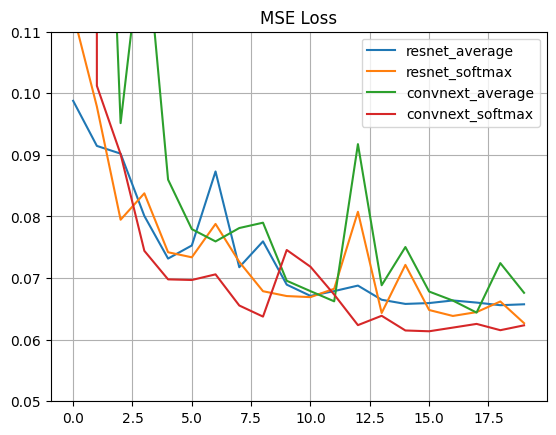

In [65]:
plt.plot(validation_scores['resnet_average']['mse_loss'], label='resnet_average')
plt.plot(validation_scores['resnet_softmax']['mse_loss'], label='resnet_softmax')
plt.plot(validation_scores['convnext_average']['mse_loss'], label='convnext_average')
plt.plot(validation_scores['convnext_softmax']['mse_loss'], label='convnext_softmax')
plt.title('MSE Loss')
plt.grid()
plt.legend(loc='best')
plt.ylim([0.05, 0.11])

(0.17, 0.26)

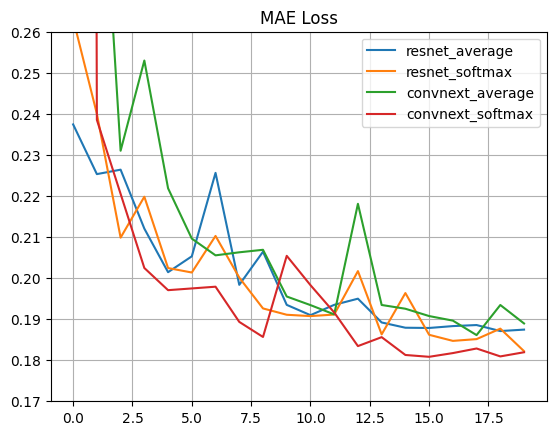

In [66]:
plt.plot(validation_scores['resnet_average']['mae_loss'], label='resnet_average')
plt.plot(validation_scores['resnet_softmax']['mae_loss'], label='resnet_softmax')
plt.plot(validation_scores['convnext_average']['mae_loss'], label='convnext_average')
plt.plot(validation_scores['convnext_softmax']['mae_loss'], label='convnext_softmax')
plt.title('MAE Loss')
plt.grid()
plt.legend(loc='best')
plt.ylim([0.17, 0.26])

## Заключение (оно же short report)


Из предоставленных советов я использовал предобученные эмбеддинги, разные свертки (в т.ч группы), и нестандартный пулинг (софтмакс). 

Я потратил огромное количество времени на обучение относительно тяжелых моделей (архитектуры а-ля resnet18), они давали результат хуже бейзлайна с семинара, что приводило меня в неистовый ужас. В последний день решил попробовать архитектуры кратно легче (буквально пара-тройка блоков), и, о чудо, получил вроде как неплохой результат. Потуги с тяжелыми архитектурами и примерные результаты можно посмотреть ниже.

Конфиг для резнета: : [[128] * 2, [1024] * 2]

Конфиг для convnext: : [[256] * 2, [512] * 2]


В принципе, модели дали примерно одинаковый результат, обучались немного нестабильно на первых эпохах. Параллельно я обучал еще более облегченные версии архитектур на т4 с размером батча 16, они дали результат не сильно хуже, этот ноутбук я так же прикреплю к дз. Из интересного, там периодически convnext взрывалась, по непонятной причине давая гигантский MSE, я это дело даже в чат скинул, буду благодарен если мне конкретно объяснят почему так происходило.Из предоставленных советов я использовал предобученные эмбеддинги, разные свертки (в т.ч группы), и нестандартный пулинг (софтмакс). 

Я потратил огромное количество времени на обучение довольно тяжелых моделей (архитектуры а-ля resnet18), они давали результат хуже бейзлайна с семинара, что приводило меня в неистовый ужас. В последний день решил попробовать архитектуры кратно легче (буквально пара-тройка блоков), и, о чудо, получил вроде как неплохой результат. Потуги с тяжелыми архитектурами и примерные результаты можно посмотреть ниже.

В принципе, модели дали примерно одинаковый результат, обучались немного нестабильно на первых эпохах. Параллельно я обучал еще более облегченные версии архитектур на т4 с размером батча 16, они дали результат не сильно хуже, этот ноутбук я так же прикреплю к дз. Из интересного, там периодически convnext взрывалась, по непонятной причине давая гигантский MSE, я это дело даже в чат скинул, буду благодарен если мне конкретно объяснят почему так происходило.

## Обещанные потуги

In [52]:
#convnext

model = SalaryPredictor().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        pred.squeeze_(1)

        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print_metrics(model, data_val, device=device)

      

epoch: 0


12239it [02:57, 68.81it/s]                           


 results:
Mean square error: 0.11752
Mean absolute error: 0.26290
epoch: 1


12239it [02:58, 68.59it/s]                           


 results:
Mean square error: 0.11864
Mean absolute error: 0.26700
epoch: 2


12239it [02:59, 68.21it/s]                           


 results:
Mean square error: 0.09423
Mean absolute error: 0.23126
epoch: 3


12239it [02:58, 68.50it/s]                           


 results:
Mean square error: 0.09835
Mean absolute error: 0.23770
epoch: 4


12239it [02:57, 68.85it/s]                           


 results:
Mean square error: 0.09332
Mean absolute error: 0.23071
epoch: 5


12239it [02:56, 69.31it/s]                           


 results:
Mean square error: 0.08951
Mean absolute error: 0.22574
epoch: 6


12239it [02:56, 69.32it/s]                           


 results:
Mean square error: 0.09001
Mean absolute error: 0.22521
epoch: 7


12239it [02:56, 69.45it/s]                           


 results:
Mean square error: 0.08691
Mean absolute error: 0.21937
epoch: 8


12239it [02:57, 68.93it/s]                           


 results:
Mean square error: 0.08315
Mean absolute error: 0.21488
epoch: 9


12239it [02:57, 69.13it/s]                           


 results:
Mean square error: 0.08267
Mean absolute error: 0.21440


In [ ]:
#resnet

model = SalaryPredictor_v3().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        pred.squeeze_(1)

        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print_metrics(model, data_val, device=device)

      

epoch: 0


12239it [04:01, 50.62it/s]                           


 results:
Mean square error: 0.11263
Mean absolute error: 0.25654
epoch: 1


12239it [04:02, 50.47it/s]                           


 results:
Mean square error: 0.11426
Mean absolute error: 0.25767
epoch: 2


12239it [04:03, 50.30it/s]                           


 results:
Mean square error: 0.09484
Mean absolute error: 0.23251
epoch: 3


12239it [03:58, 51.31it/s]                           


 results:
Mean square error: 0.11819
Mean absolute error: 0.24753
epoch: 4


12239it [04:00, 50.82it/s]                           


 results:
Mean square error: 0.08584
Mean absolute error: 0.21607
epoch: 9


12239it [04:00, 50.99it/s]                           


 results:
Mean square error: 0.79253
Mean absolute error: 0.27940
epoch: 10


12239it [04:00, 50.82it/s]                           


 results:
Mean square error: 0.08892
Mean absolute error: 0.22173
epoch: 11


12239it [04:01, 50.78it/s]                           


 results:
Mean square error: 0.08812
Mean absolute error: 0.21759
epoch: 12


12239it [03:59, 51.02it/s]                           


 results:
Mean square error: 0.08396
Mean absolute error: 0.21523
epoch: 13


12239it [04:00, 50.79it/s]                           


 results:
Mean square error: 0.08628
Mean absolute error: 0.21434
epoch: 14


 96%|█████████▌| 11776/12238 [03:50<00:09, 51.08it/s]

## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback(keras)](https://keras.io/callbacks/#earlystopping) or in [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!